In [1]:
# Required Packages
import numpy as np  # For matrix manipulation
import pandas as pd  # For output/input data processing
import matplotlib.pyplot as plt  # For visualizations
#from csaps import csaps #https://csaps.readthedocs.io/en/latest/

In [2]:
# Some aesthetic options
np.set_printoptions(suppress=True, linewidth=300, formatter={'float': '{: 0.9f}'.format})
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [16]:
# Global Parameters
starting_age = 20
max_age = 100
N = 100000  # Size of sample populations

# State Structure
health_states = {'Healthy': 0,
                 'LR Polyp': 1,
                 'HR Polyp': 2,
                 'Undetected CRC Local': 3,
                 'Undetected CRC Regional': 4,
                 'Undetected CRC Distant': 5,
                 'Detected CRC Local': 6,
                 'Detected CRC Regional': 7,
                 'Detected CRC Distant': 8,
                 'Cancer Death': 9,
                 'Healthy ACM': 10,
                 'Cancer ACM': 11,
                 'Polyp ACM': 12, # death while in polyp state
                 'uCRC ACM': 13} # death while in undiagnosed state

# Age Groupings (len=11)
ages = {"20-29":0, "30-39":1, "40-49":2, "50-54":3, "55-59":4, "60-64":5, 
        "65-69":6, "70-74":7, "75-79":8, "80-84":9, "85+":10}

starting_pop = np.zeros((len(health_states),1)) # (14,1)
starting_pop[0,0]=N # Everyone starts in healthy state

# Loading WHO Mortality
acm_dr = pd.read_excel("data/acm_dr.xlsx", sheet_name="ACM_5Y")
avg20 = np.mean(acm_dr.loc[0, 'Prob'] + acm_dr.loc[1, 'Prob'])
avg30 = np.mean(acm_dr.loc[2, 'Prob'] + acm_dr.loc[3, 'Prob'])
avg40 = np.mean(acm_dr.loc[4, 'Prob'] + acm_dr.loc[5, 'Prob'])
acm_dr = acm_dr.drop([0,1,2,3,4,5])
avg = {"Age":[20,30,40],
      "Prob":[avg20,avg30,avg40]}
avg_df = pd.DataFrame(avg)
who_acm = pd.concat([avg_df, acm_dr]).reset_index(drop=True)

# Loading SEER Survival
seer_surv = pd.read_excel("data/survival_km.xlsx", sheet_name="Survival") # age layers
#seer_surv = seer_surv[seer_surv['Age']<=84].reset_index() # starting age 20, age layers=11 groups

## Targets ##

# Loading Globocan incidence
# dr_inc = pd.read_excel("data/incidence_dr_globocan.xlsx", sheet_name="Globocan") # 5y stage dist
# dr_inc = dr_inc[dr_inc['Age']!='85+']
# dr_inc = dr_inc[dr_inc['Age']!='20-85+'].reset_index(drop=True)
# dr_inc_arr = dr_inc['Crude Rate'].values

# Globocan 1y * US stage distribution
#dr_inc = pd.read_excel("data/incidence_dr_globocan.xlsx", sheet_name="1Y INC US STAGE DIST")  # Globocan * US stage dist

# US 1y * DR age-specific factor
dr_inc = pd.read_excel("data/incidence_dr_globocan.xlsx", sheet_name="DR incidence factor")  # US rate by stage * DR factor (per age)
dr_inc = dr_inc.iloc[:65,:]

# Load US SEER inc
# seer_inc = pd.read_excel("data/incidence_crude.xlsx", sheet_name="1975-1990 Adj")
# seer_inc = seer_inc[seer_inc['Age']>=20].reset_index() # starting age 20, 65 ages
# seer_inc = seer_inc[seer_inc['Age']<=84].reset_index() # starting age 20, 65 ages

# DR stage dist
tot=44+74+85+131
ploc_dr=(44+74)/tot
preg_dr=85/tot
pdis_dr=131/tot

# Loading polyp targets
polyp_prev = pd.read_excel("data/polyp_targets.xlsx", sheet_name="Sheet1")
polyp_targets=polyp_prev['Value'].to_numpy() # uCRC, polyp, uCRC + polyp
dr_factor_flat = 0.416391039 

In [17]:
# Original SEER rates
local_rate = dr_inc['Local Rate']
regional_rate = dr_inc['Regional Rate']
distant_rate = dr_inc['Distant Rate']

# Calculate new stage-specific rates
loc_new = local_rate * 0.85
reg_new = regional_rate * 0.85
dis_new = distant_rate * 1.2

# Normalize the new rates to keep the overall incidence the same
total_original_rate = local_rate.sum() + regional_rate.sum() + distant_rate.sum()
total_new_rate = loc_new.sum() + reg_new.sum() + dis_new.sum()

normalized_local_rate = loc_new * (total_original_rate / total_new_rate)
normalized_regional_rate = reg_new * (total_original_rate / total_new_rate)
normalized_distant_rate = dis_new * (total_original_rate / total_new_rate)

In [ ]:
# from_state, to_state, slope, intercept

def create_matrix():
    tmat = np.zeros((2, len(health_states),len(health_states))) # slope/int, from_state, to_state
    tmat[:,0,1]=[0.00008, 0.0012]  # Healthy to LR
    tmat[:,1,2]=[0.00008, 0.0353]  # LR to HR
    tmat[:,2,3]=[0.00010, 0.0408]  # HR to uLoc
    tmat[:,3,4]=[0.00001, 0.4576]  # uLoc to uReg
    tmat[:,4,5]=[0.00430, 0.4921]  # uReg to uDis
    tmat[:,3,6]=[0.00190, 0.2127]  # uLoc to dLoc
    tmat[:,4,7]=[0.00001, 0.6061]  # uReg to dReg
    tmat[:,5,8]=[0.00060, 0.8974]  # uDis to dDis
    
    tmat=constrain(tmat)
    
    return tmat


def constrain(matrix):
    
    matrix[0,:,:] = matrix[0,:,:].clip(0.00001,1)
    matrix[1,:,:] = matrix[1,:,:].clip(0.00001,1)
    
    matrix[1,1,2] = np.maximum(matrix[1,0,1], matrix[1,1,2])  # LR to HR > Healthy to LR (intercept)
    matrix[1,3,6] = np.minimum(matrix[1,3,6], matrix[1,4,7])  # uLoc to dLoc < uReg to dReg (intercept)
    matrix[1,4,7] = np.minimum(matrix[1,4,7], matrix[1,5,8])  # uReg to dReg < uDis to dDis (intercept)
    
    return matrix
     

def run_markov(matrix, max_age=100,starting_age=20):
    current_age = starting_age
    pop, pop_log = starting_pop.copy(), starting_pop.copy()  # current population in each state (14,1)
    inc_log = np.zeros(pop.shape)  # to track new incidences in each state 
    age_layer=0
    acm_states=[10,12,12,13,13,13,11,11,11]
    mat=matrix.copy()
    while current_age < max_age:
        yr_inc = np.zeros(pop.shape)  # Initialize yearly incidence array
        
        for state in range(len(pop)):

            if state >= 9:  # Terminal states, no outflow
                continue
            
            acm_state=acm_states[state]  # Assign ACM state
                
            # Handling ACM
            acm_deaths = pop[state] * who_acm['Prob'][age_layer]
            yr_inc[acm_state] += acm_deaths 
            pop[state] -= acm_deaths
            
            # Handling CSD
            if 6 <= state <= 8:
                if state==6: csd_deaths = pop[state]*seer_surv['Local'][age_layer] 
                if state==7: csd_deaths = pop[state]*seer_surv['Regional'][age_layer] 
                if state==8: csd_deaths = pop[state]*seer_surv['Distant'][age_layer] 
                yr_inc[9] += csd_deaths 
                pop[state] -= csd_deaths
            
            # Handling detections
            if 3 <= state <= 5:
                param_detect = mat[0,state,state+3]*age_layer + mat[1,state,state+3]
                detection = pop[state] * param_detect
                yr_inc[state+3] += detection
                pop[state] -= detection
                
            # Handling progression
            if state < 5:  # Only states < 5 have progressions
                param_progress = mat[0,state, state+1]*age_layer + mat[1,state,state+1]
                progression = pop[state] * param_progress
                yr_inc[state+1] += progression
                pop[state] -= progression
        
        pop += yr_inc  # Update population after all transitions
        pop_log = np.concatenate((pop_log,pop), axis=1)  # will be (14,65) by end
        inc_log = np.concatenate((inc_log, yr_inc), axis=1)  # will be (14, 65) by end
        
        current_age += 1
        if current_age in [30,40,50,55,60,65,70,75,80,85]:
            age_layer += 1
            
    inc_log = inc_log[:, :]
    inc_rate = inc_log.copy()
    pop_log = pop_log[:, :]
    
    dead_factor = np.divide(N, N-pop_log[9:,:].sum(axis=0)) # inc and prev denominator is out of living only
    prevalence = np.zeros(pop_log.shape) #(14,81)
    
    for state in range(14):
        inc_rate[state,:] = np.multiply(inc_rate[state,:], dead_factor) 
        prevalence[state,:] = np.multiply(pop_log[state,:], dead_factor)

    return inc_rate, prevalence, pop_log, inc_log


# Calculate score based on difference between model outputs and targets
def objective(log, matrix, i, a_inc=1, a_pol=1):
    inc, inc_log = log[0], log[3]
    score = 0
    
    # Incidence penalty using SEER distribution * DR age-specific factor
#     score += np.square(inc[6,:65] - a_inc*dr_inc['Local Rate']).sum() # Local
#     score += np.square(inc[7,:65] - a_inc*dr_inc['Regional Rate']).sum() # Regional
#     score += np.square(inc[8,:65] - a_inc*dr_inc['Distant Rate']).sum() # Distant 
    
    # New target multipliers
    local_multiplier = 0.8
    regional_multiplier = 0.9
    distant_multiplier = 1.2
    
    sum_weight = 1.0
    proportion_weight = 0.1  # This can be adjusted to provide more or less slack

    # Original SEER rates
    local_rate = dr_inc['Local Rate']
    regional_rate = dr_inc['Regional Rate']
    distant_rate = dr_inc['Distant Rate']

    # Calculate the new target proportions
    target_local_rate = local_rate * local_multiplier
    target_regional_rate = regional_rate * regional_multiplier
    target_distant_rate = distant_rate * distant_multiplier
    
    # Compute the sum of the incidence rates
    observed_sum_rate = inc[6,:65] + inc[7,:65] + inc[8,:65]
    target_sum_rate = a_inc * (local_rate + regional_rate + distant_rate)

    # Normalize the target rates
    total_target_rate = target_local_rate + target_regional_rate + target_distant_rate
    normalized_local_rate = target_local_rate / total_target_rate
    normalized_regional_rate = target_regional_rate / total_target_rate
    normalized_distant_rate = target_distant_rate / total_target_rate
    
    # Calculate the penalties
    sum_penalty = np.square(observed_sum_rate - target_sum_rate).sum()
    local_penalty = np.square((inc[6,:65] / observed_sum_rate) - normalized_local_rate).sum()
    regional_penalty = np.square((inc[7,:65] / observed_sum_rate) - normalized_regional_rate).sum()
    distant_penalty = np.square((inc[8,:65] / observed_sum_rate) - normalized_distant_rate).sum()

    # Combine the penalties with the appropriate weights
    score += sum_weight * sum_penalty
    score += proportion_weight * (local_penalty + regional_penalty + distant_penalty)
    
#     # Adjusted stage distribution
#     score += np.square(inc[6, :65] - a_inc * normalized_local_rate).sum()  # Local
#     score += np.square(inc[7, :65] - a_inc * normalized_regional_rate).sum()  # Regional
#     score += np.square(inc[8, :65] - a_inc * normalized_distant_rate).sum()  # Distant
    
    # Polyp prevalence penalty (pooled) * flat DR factor
    score += (1/np.sqrt(35656))*np.square(inc_log[12,:].sum() - dr_factor_flat*N*polyp_targets[1]) # polyps
    score += (1/np.sqrt(31434))*np.square(inc_log[13,:].sum() - dr_factor_flat*N*polyp_targets[0]) # uCRC
    
    return score


# Adjust transition matrix
points = [(0,1),(3,6),(4,7),(5,8)] #(4 points to adjust, slope and int = 8)
def step(matrix, step_size, num_adj=7):
    new_matrix=np.copy(matrix)
    slope_int = np.random.randint(2, size=num_adj)
    cells = np.random.choice(len(points), size=num_adj, replace=True)
    for i in range(num_adj):
        new_matrix[slope_int[i], points[cells[i]][0], points[cells[i]][1]] += np.random.uniform(low=-step_size, high=step_size)
    new_matrix = constrain(new_matrix)
    return new_matrix


def simulated_annealing(n_iterations, step_size, start_mat=None, verbose=False, a_inc=1, a_pol=1):
    if start_mat is None:
        best = create_matrix()
    else:
        best = np.copy(start_mat)
    best_eval = objective(run_markov(best),best,1)  # evaluate the initial point
    curr, curr_eval = best, best_eval  # current working solution
    for i in range(n_iterations):  # Running algorithm
        candidate = np.copy(curr)
        candidate = step(candidate, step_size)
        candidate_log = run_markov(candidate)
        candidate_eval = objective(candidate_log,candidate,i,a_inc,a_pol)  # Evaluate candidate point
        
        if candidate_eval < best_eval:
            best, best_eval = candidate, candidate_eval 
        # t = 10 / float(i+1)  # calculate temperature for current epoch
        t = 1 /(1+np.log(i+1))
         
        if verbose and i%1000==0:
            inc_log=candidate_log[3]
            total_dxd=np.sum(inc_log[6:9,:])/N 
            print(i, ": ", round(best_eval, 5),"   CRC: ", round(total_dxd,5))

            
        diff = candidate_eval - curr_eval  # difference between candidate and current point evaluation
        metropolis = np.exp(-diff / t)  # calculate metropolis acceptance criterion        
        if diff < 0 or np.random.random() < metropolis:  # check if we should keep the new point
            curr, curr_eval = candidate, candidate_eval  # store the new current point
    print(best_eval)
    return best

In [ ]:
# Load US tmat as starting point
tmat=create_matrix()
tmat_load=pd.read_excel("data/Transition Matrices/us_trans_5_5.xlsx", sheet_name="Linear")
tmat[:,0,1]=tmat_load.iloc[:,1].values # Healthy to LR
tmat[:,1,2]=tmat_load.iloc[:,2].values  # LR to HR
tmat[:,2,3]=tmat_load.iloc[:,3].values  # HR to uLoc
tmat[:,3,4]=tmat_load.iloc[:,4].values  # uLoc to uReg
tmat[:,4,5]=tmat_load.iloc[:,5].values  # uReg to uDis
tmat[:,3,6]=tmat_load.iloc[:,6].values # uLoc to dLoc
tmat[:,4,7]=tmat_load.iloc[:,7].values  # uReg to dReg
tmat[:,5,8]=tmat_load.iloc[:,8].values  # uDis to dDis

In [ ]:
result = simulated_annealing(10000, 0.0001, start_mat=tmat, verbose=True, a_inc=1, a_pol=1)
result = simulated_annealing(50000, 0.00005, start_mat=result, verbose=True, a_inc=1, a_pol=1)
result = simulated_annealing(50000, 0.00001, start_mat=result, verbose=True, a_inc=1, a_pol=1)
#result = simulated_annealing(250000, 0.000005, start_mat=result, verbose=True, a_inc=1, a_pol=1)

In [ ]:
curr_tmat=result.copy()

In [ ]:
inc_adj, prev, pop_log, inc_log = run_markov(curr_tmat)
inc_adjdf, prevdf, pop_logdf, inc_logdf = pd.DataFrame(inc_adj), pd.DataFrame(prev), pd.DataFrame(pop_log), pd.DataFrame(inc_log)

In [ ]:
x_values = np.linspace(20,100,81)

plt.plot(dr_inc['Age'], dr_inc['Local Rate'], label = 'Local (Globocan/SEER)', color='b',linestyle="dotted")
plt.plot(dr_inc['Age'], dr_inc['Regional Rate'], label = 'Regional (Globocan/SEER)', color='r', linestyle="dotted")
plt.plot(dr_inc['Age'], dr_inc['Distant Rate'],  label='Distant (Globocan/SEER)', color='g',linestyle="dotted")
plt.plot(x_values, inc_adj[6,:], label='Local (Model)', color='b')
plt.plot(x_values, inc_adj[7,:],  label='Regional (Model)', color='r')
plt.plot(x_values, inc_adj[8,:],  label='Distant (Model)', color='g')
plt.legend()
plt.title('Incidence of Local, Regional, and Distant States')
plt.xlabel('Time Point / Age Group')
plt.ylabel('incidence')
plt.show()

plt.plot(dr_inc['Age'], dr_inc['Local Rate'].cumsum(), label = 'Local (SEER*DR Factor)', color='b',linestyle="dotted")
plt.plot(dr_inc['Age'], dr_inc['Regional Rate'].cumsum(), label = 'Regional (SEER*DR Factor)', color='r',linestyle="dotted")
plt.plot(dr_inc['Age'], dr_inc['Distant Rate'].cumsum(), label = 'Distant (SEER*DR Factor)', color='g',linestyle="dotted")
plt.plot(x_values, inc_adj[6,:].cumsum(), label='Local (Model)', color='b')
plt.plot(x_values, inc_adj[7,:].cumsum(), label='Regional (Model)', color='r')
plt.plot(x_values, inc_adj[8,:].cumsum(), label='Distant (Model)', color='g')
plt.legend()
plt.title('Cumulative Incidence of Local, Regional, and Distant States')
plt.xlabel('Time Point / Age Group')
plt.ylabel('incidence')
plt.show()

In [5]:
worse = pd.read_excel("data/stage_dist_outputs_5_30.xlsx", sheet_name="Worse calc")
better = pd.read_excel("data/stage_dist_outputs_5_30.xlsx", sheet_name="Better calc")

In [13]:
inc_adj = worse.iloc[:-,:]

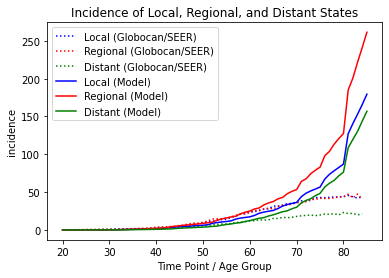

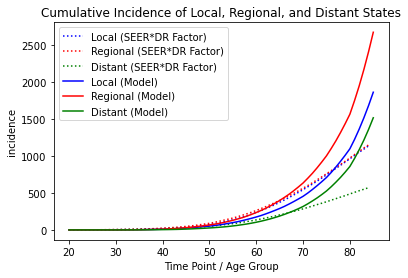

In [18]:
x_values = np.linspace(20,85,66)

plt.plot(dr_inc['Age'], dr_inc['Local Rate'], label = 'Local (Globocan/SEER)', color='b',linestyle="dotted")
plt.plot(dr_inc['Age'], dr_inc['Regional Rate'], label = 'Regional (Globocan/SEER)', color='r', linestyle="dotted")
plt.plot(dr_inc['Age'], dr_inc['Distant Rate'],  label='Distant (Globocan/SEER)', color='g',linestyle="dotted")
plt.plot(x_values, N*inc_adj['L inc'], label='Local (Model)', color='b')
plt.plot(x_values, N*inc_adj['R inc'],  label='Regional (Model)', color='r')
plt.plot(x_values, N*inc_adj['D inc'],  label='Distant (Model)', color='g')
plt.legend()
plt.title('Incidence of Local, Regional, and Distant States')
plt.xlabel('Time Point / Age Group')
plt.ylabel('incidence')
plt.show()

plt.plot(dr_inc['Age'], dr_inc['Local Rate'].cumsum(), label = 'Local (SEER*DR Factor)', color='b',linestyle="dotted")
plt.plot(dr_inc['Age'], dr_inc['Regional Rate'].cumsum(), label = 'Regional (SEER*DR Factor)', color='r',linestyle="dotted")
plt.plot(dr_inc['Age'], dr_inc['Distant Rate'].cumsum(), label = 'Distant (SEER*DR Factor)', color='g',linestyle="dotted")
plt.plot(x_values, N*inc_adj['L inc'].cumsum(), label='Local (Model)', color='b')
plt.plot(x_values, N*inc_adj['R inc'].cumsum(), label='Regional (Model)', color='r')
plt.plot(x_values, N*inc_adj['D inc'].cumsum(), label='Distant (Model)', color='g')
plt.legend()
plt.title('Cumulative Incidence of Local, Regional, and Distant States')
plt.xlabel('Time Point / Age Group')
plt.ylabel('incidence')
plt.show()

In [ ]:
## Stages
dr_plot = pd.read_excel("data/incidence_dr_globocan.xlsx", sheet_name="1Y INC")

plt.plot(dr_inc['Age'], dr_inc['Total Rate'], label = 'CRC (SEER*DR Factor)', color='b',linestyle="dotted")
plt.plot(x_values, np.sum(inc_adj[6:9,:],axis=1), label='CRC (Model)', color='b')
plt.title('Incidence rate by age per 100k')
plt.xlabel('Time Point / Age Group')
plt.ylabel('incidence')
plt.show()

plt.plot(dr_inc['Age'], dr_inc['Total Rate'].cumsum(),label = 'CRC (SEER*DR Factor)', color='b',linestyle="dotted")
plt.plot(x_values, np.sum(inc_adj[6:9,:].cumsum(),axis=1), label='CRC (Model)', color='b')
plt.title('Cumulative inc')
plt.xlabel('Time Point / Age Group')
plt.ylabel('incidence')
plt.show()
plt.show()

plt.plot(x_values, inc_adj[6,:], label='Local (Model)', color='b')
plt.plot(x_values, inc_adj[7,:],  label='Regional (Model)', color='r')
plt.plot(x_values, inc_adj[8,:],  label='Distant (Model)', color='g')
plt.legend()
plt.title('Incidence of Local, Regional, and Distant States')
plt.xlabel('Time Point / Age Group')
plt.ylabel('incidence')
plt.show()
         
plt.plot(x_values, inc_adj[6,:].cumsum(), label='Local (Model)', color='b')
plt.plot(x_values, inc_adj[7,:].cumsum(),  label='Regional (Model)', color='r')
plt.plot(x_values, inc_adj[8,:].cumsum(),  label='Distant (Model)', color='g')
plt.legend()
plt.title('Cumulative Incidence of Local, Regional, and Distant States')
plt.xlabel('Time Point / Age Group')
plt.ylabel('incidence')
plt.show()

In [ ]:
print(pd.DataFrame(result[0]))

In [ ]:
def get_tps_only(curr_tmat):
    points = [(0,1),(1,2),(2,3),(3,4),(4,5),(3,6),(4,7),(5,8)]
    df=pd.DataFrame()
    for i in range(curr_tmat.shape[0]):
        for j in range(len(points)):
            df.loc[i,j]=curr_tmat[i, points[j][0],points[j][1]]
    df.columns=['Healthy LR','LR to HR', 'HR to uLoc', 'uLoc to uReg', 'uReg to uDis', 'uLoc to dLoc', 'uReg to dReg','uDis to dDis']
    return df

In [ ]:
tps = get_tps_only(curr_tmat)
tps.to_clipboard()
print(tps)

In [ ]:
pooled_polyp_50 =inc_log[12,:30].sum()/inc_log[9:,:30].sum()
pooled_polyp_70 =inc_log[12,:50].sum()/inc_log[9:,:50].sum()
pooled_polyp_100=inc_log[12,:].sum()/inc_log[9:,:].sum()
print(pooled_polyp_50, pooled_polyp_70, pooled_polyp_100)

In [ ]:
p50=inc_adj[1:3,:30].sum()/N
p70=inc_adj[1:3,:50].sum()/N
p100=inc_adj[1:3,:].sum()/N
print(p50,p70,p100)

In [ ]:
def outputs_to_df(inc_log):
    # Calculating the various metrics
    pooled_polyp_prev_20_100 = inc_log[12,:].sum() / N
    pooled_uCRC_prev_20_100 = inc_log[13,:].sum() / N
    pooled_polyp_uCRC_prev_20_100 = inc_log[12:,:].sum() / N

    pooled_polyp_prev_20_85 = inc_log[12,:65].sum() / N
    pooled_uCRC_prev_20_85 = inc_log[13,:65].sum() / N
    pooled_polyp_uCRC_prev_20_85 = inc_log[12:,:65].sum() / N

    total_cancer_inc_20_85 = np.sum(inc_log[6:9,:65]) / N
    total_cancer_inc_20_100 = np.sum(inc_log[6:9,:]) / N

    outputs = {
        "Python 20-85": {
            "CRC inc": total_cancer_inc_20_85,
            "CSD": "",  
            "Polyp prev": pooled_polyp_prev_20_85,
            "uCRC prev": pooled_uCRC_prev_20_85,
            "Polyp+uCRC prev": pooled_polyp_uCRC_prev_20_85
        },
        "Python 20-100": {
            "CRC inc": total_cancer_inc_20_100,
            "CSD": "",  
            "Polyp prev": pooled_polyp_prev_20_100,
            "uCRC prev": pooled_uCRC_prev_20_100,
            "Polyp+uCRC prev": pooled_polyp_uCRC_prev_20_100
        },
        "TreeAge 20-100": {
            "CRC inc": "",
            "CSD": "",
            "Polyp prev": "",
            "uCRC prev": "",
            "Polyp+uCRC prev": ""
        }
    }

    outputsdf = pd.DataFrame(outputs)
    print(outputsdf)
    outputsdf.to_clipboard(index=True)
    
    return outputsdf